In [1]:
import numpy as np
rng = np.random.default_rng(0)
NB6 = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]], dtype=int)

def make_generator_mask(k_keep: int):
    # 3x3x3에서 중심에서 먼 순으로 k개 True(고체) 유지 → 공극 네트워크 확보
    coords=[]
    for z in range(3):
        for y in range(3):
            for x in range(3):
                m = abs(x-1)+abs(y-1)+abs(z-1)
                coords.append(((z,y,x), m))
    coords.sort(key=lambda t: t[1], reverse=True)
    gen = np.zeros((3,3,3), dtype=bool)
    for i in range(k_keep):
        (z,y,x),_ = coords[i]; gen[z,y,x]=True
    return gen  # True=solid

def build_menger(level=3, k_keep=20):
    solid = np.ones((1,1,1), dtype=bool)
    gen = make_generator_mask(k_keep)
    for _ in range(level):
        solid = np.kron(solid, gen)
    return solid  # True=solid, False=pore

def build_uniform(level=3):
    n = 3**level
    solid = np.ones((n,n,n), dtype=bool)
    # 십자형 대공 채널을 뚫어서 균일 공극망 생성(간단화)
    w = max(2, n//12)  # 채널 폭
    solid[:, :, n//2-w:n//2+w] = False
    solid[:, n//2-w:n//2+w, :] = False
    solid[n//2-w:n//2+w, :, :] = False
    return solid

def masks_from_solid(solid: np.ndarray):
    pore = ~solid
    Z,Y,X = solid.shape
    pad = np.pad(solid, 1, constant_values=False)
    surf = np.zeros_like(solid, dtype=bool)
    for dz,dy,dx in NB6:
        neigh = pad[1+dz:1+dz+Z, 1+dy:1+dy+Y, 1+dx:1+dx+X]
        surf |= (solid & (~neigh))  # 고체이면서 이웃에 공극 존재
    bpore = np.zeros_like(pore, dtype=bool)
    bpore[0,:,:]|=pore[0,:,:];  bpore[-1,:,:]|=pore[-1,:,:]
    bpore[:,0,:]|=pore[:,0,:];  bpore[:,-1,:]|=pore[:,-1,:]
    bpore[:,:,0]|=pore[:,:,0];  bpore[:,:,-1]|=pore[:,:,-1]
    return pore, surf, bpore


In [2]:
def init_fields(solid: np.ndarray, n_atm=50):
    pore, surf, bpore = masks_from_solid(solid)
    A = np.zeros_like(solid, dtype=np.int32)  # reactant
    P = np.zeros_like(solid, dtype=np.int32)  # product
    A[bpore] = n_atm  # 외부 대기층
    return pore, surf, bpore, A, P

def mcs_step(solid, pore, bpore, A, P, Ndif=1, Pr=0.1):
    Z,Y,X = solid.shape
    intrinsic = 0
    apparent  = 0
    idx = np.array(np.where(pore)).T
    rng.shuffle(idx)

    for z,y,x in idx:
        occ = A[z,y,x] + P[z,y,x]
        if occ <= 0: 
            continue
        is_A = (rng.integers(occ) < A[z,y,x])
        dz,dy,dx = NB6[rng.integers(6)]

        # 최대 Ndif 직진 (공극만 통과, 고체 만나면 정지)
        zn,yn,xn = z,y,x
        steps=0
        while steps < Ndif:
            z2,y2,x2 = zn+dz, yn+dy, xn+dx
            if not (0<=z2<Z and 0<=y2<Y and 0<=x2<X): break
            if solid[z2,y2,x2]: break
            zn,yn,xn = z2,y2,x2
            steps += 1

        # 이동 수용확률 P_d (목적지 총점유가 낮을수록 유리)
        n_src = A[z,y,x] + P[z,y,x]
        n_dst = A[zn,yn,xn] + P[zn,yn,xn]
        Pd = np.exp(-(n_dst - n_src))
        Pd = 1.0 if Pd>1 else Pd
        if rng.random() < Pd:
            if is_A: A[z,y,x]-=1; A[zn,yn,xn]+=1
            else:    P[z,y,x]-=1; P[zn,yn,xn]+=1
            z,y,x = zn,yn,xn

        # 표면 인접 시 반응(A만)
        if is_A and A[z,y,x]>0:
            touched = False
            for dz2,dy2,dx2 in NB6:
                zz,yy,xx = z+dz2, y+dy2, x+dx2
                if 0<=zz<Z and 0<=yy<Y and 0<=xx<X and solid[zz,yy,xx]:
                    touched=True; break
            if touched and rng.random()<Pr:
                A[z,y,x]-=1; P[z,y,x]+=1
                intrinsic += 1

        # 경계 공극의 P는 외부로 방출(측정=apparent rate)
        if bpore[z,y,x] and P[z,y,x]>0:
            apparent += P[z,y,x]
            P[z,y,x] = 0

    return intrinsic, apparent


In [3]:
def run_sim(solid, Ndif=1, Pr=0.1, mcs_total=1200, mcs_burn=600, n_atm=50):
    pore, surf, bpore, A, P = init_fields(solid, n_atm=n_atm)
    intr_hist=[]; app_hist=[]
    for _ in range(mcs_total):
        intr, app = mcs_step(solid, pore, bpore, A, P, Ndif=Ndif, Pr=Pr)
        intr_hist.append(intr); app_hist.append(app)
    intr_ss = np.mean(intr_hist[mcs_burn:])
    app_ss  = np.mean(app_hist[mcs_burn:])
    return intr_ss, app_ss, np.array(intr_hist), np.array(app_hist)

def sweep_Pr_curves(struct="fractal", level=3, k_keep=20, Ndif=1, Pr_list=None):
    if Pr_list is None:
        Pr_list = np.geomspace(5e-3, 1.0, 8)
    rates=[]
    for Pr in Pr_list:
        solid = build_menger(level, k_keep) if struct=="fractal" else build_uniform(level)
        intr, app, *_ = run_sim(solid, Ndif=Ndif, Pr=Pr, mcs_total=1200, mcs_burn=600, n_atm=50)
        rates.append(app)
    return np.array(Pr_list), np.array(rates)

def sweep_D_opt(level=3, k_values=(12,14,16,18,20,22,24), Ndif=10, Pr=0.1):
    Ds=[]; rates=[]
    for k in k_values:
        solid = build_menger(level, k)
        intr, app, *_ = run_sim(solid, Ndif=Ndif, Pr=Pr, mcs_total=1000, mcs_burn=500, n_atm=50)
        Ds.append(np.log(k)/np.log(3)); rates.append(app)
    return np.array(Ds), np.array(rates)


In [4]:
# === Step 4: Monte Carlo 이동/반응 커널 (Guo & Keil 2003 규칙) ===
import numpy as np

# 전 셀에서 이미 있다면 재정의 안 해도 됨
rng = np.random.default_rng(0)
NB6 = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]], dtype=int)

def masks_from_solid(solid: np.ndarray):
    """공극(pore), 표면(surface), 경계 공극(boundary pore) 마스크 계산"""
    pore = ~solid
    Z,Y,X = solid.shape
    pad = np.pad(solid, 1, constant_values=False)
    surf = np.zeros_like(solid, dtype=bool)
    for dz,dy,dx in NB6:
        neigh = pad[1+dz:1+dz+Z, 1+dy:1+dy+Y, 1+dx:1+dx+X]
        surf |= (solid & (~neigh))
    bpore = np.zeros_like(pore, dtype=bool)
    bpore[0,:,:]  |= pore[0,:,:];   bpore[-1,:,:] |= pore[-1,:,:]
    bpore[:,0,:]  |= pore[:,0,:];   bpore[:,-1,:] |= pore[:,-1,:]
    bpore[:,:,0]  |= pore[:,:,0];   bpore[:,:,-1] |= pore[:,:,-1]
    return pore, surf, bpore

def init_fields(solid: np.ndarray, n_atm=50):
    """
    초기 상태: 경계 공극에 반응물 A(대기층) 채움, 생성물 P=0
    """
    pore, surf, bpore = masks_from_solid(solid)
    A = np.zeros_like(solid, dtype=np.int32)  # reactant
    P = np.zeros_like(solid, dtype=np.int32)  # product
    A[bpore] = int(n_atm)
    return pore, surf, bpore, A, P

def mcs_step(solid, pore, bpore, A, P, Ndif=1, Pr=0.1):
    """
    한 MCS: 모든 공극셀을 랜덤 순서로 순회
      1) (A/P) 분자 선택(농도비), 2) 방향 선택, 3) 최대 Ndif 직진(공극만),
      4) 이동 수용확률 P_d (목적지 총점유 낮을수록 유리), 5) 표면 인접시 A->P (확률 Pr),
      6) 경계 공극의 P는 외부로 방출(측정 레이트에 더함)
    반환: intrinsic(내부 생성), apparent(외부 방출)
    """
    Z,Y,X = solid.shape
    intrinsic = 0
    apparent  = 0

    # 공극 좌표를 랜덤 순서로
    idx = np.array(np.where(pore)).T
    rng.shuffle(idx)

    for z,y,x in idx:
        occ = A[z,y,x] + P[z,y,x]
        if occ <= 0:
            continue

        # 1) 분자 선택 (농도비)
        is_A = (rng.integers(occ) < A[z,y,x])

        # 2) 방향 선택
        dz,dy,dx = NB6[rng.integers(6)]

        # 3) 최대 Ndif 직진(고체 만나면 정지)
        zn,yn,xn = z,y,x
        steps = 0
        while steps < Ndif:
            z2,y2,x2 = zn+dz, yn+dy, xn+dx
            if not (0<=z2<Z and 0<=y2<Y and 0<=x2<X):
                break
            if solid[z2,y2,x2]:      # 고체면 더 전진 불가
                break
            zn,yn,xn = z2,y2,x2
            steps += 1

        # 4) 이동 수용확률 P_d (목적지 총점유 낮을수록 유리, Metropolis 형태)
        n_src = A[z,y,x] + P[z,y,x]
        n_dst = A[zn,yn,xn] + P[zn,yn,xn]
        Pd = np.exp(-(n_dst - n_src))
        if Pd > 1.0: Pd = 1.0
        if rng.random() < Pd:
            if is_A:
                A[z,y,x] -= 1; A[zn,yn,xn] += 1
            else:
                P[z,y,x] -= 1; P[zn,yn,xn] += 1
            z,y,x = zn,yn,xn  # 위치 갱신

        # 5) 표면 인접이면 A -> P (확률 Pr)
        if is_A and A[z,y,x] > 0:
            touched = False
            for dz2,dy2,dx2 in NB6:
                zz,yy,xx = z+dz2, y+dy2, x+dx2
                if 0<=zz<Z and 0<=yy<Y and 0<=xx<X and solid[zz,yy,xx]:
                    touched = True; break
            if touched and rng.random() < Pr:
                A[z,y,x] -= 1; P[z,y,x] += 1
                intrinsic += 1

        # 6) 경계 공극의 P는 외부로 방출 (apparent rate)
        if bpore[z,y,x] and P[z,y,x] > 0:
            apparent += P[z,y,x]
            P[z,y,x] = 0

    return intrinsic, apparent

def run_sim(solid, Ndif=1, Pr=0.1, mcs_total=1200, mcs_burn=600, n_atm=50):
    """
    전체 시뮬레이션 실행: mcs_total 스텝 동안 intrinsic/apparent 기록,
    버닝 이후 평균값을 steady-state rate로 반환
    """
    pore, surf, bpore, A, P = init_fields(solid, n_atm=n_atm)
    intr_hist=[]; app_hist=[]
    for _ in range(mcs_total):
        intr, app = mcs_step(solid, pore, bpore, A, P, Ndif=Ndif, Pr=Pr)
        intr_hist.append(intr); app_hist.append(app)
    intr_hist = np.asarray(intr_hist); app_hist = np.asarray(app_hist)
    intr_ss = intr_hist[mcs_burn:].mean() if mcs_total>mcs_burn else intr_hist.mean()
    app_ss  = app_hist[mcs_burn:].mean()  if mcs_total>mcs_burn else app_hist.mean()
    return intr_ss, app_ss, intr_hist, app_hist

# --- (선택) 빠른 동작 테스트 ---
# 만약 solid가 아직 없다면, 아래 예시 한 줄을 잠깐 풀어서 구조를 만든 뒤 테스트 가능:
# def build_uniform(level=3):
#     n=3**level; solid=np.ones((n,n,n),bool); w=max(2,n//12)
#     solid[:,:,n//2-w:n//2+w]=False; solid[:,n//2-w:n//2+w,:]=False; solid[n//2-w:n//2+w,:,:]=False; return solid
# solid = build_uniform(level=3)
# intr_ss, app_ss, intr_hist, app_hist = run_sim(solid, Ndif=10, Pr=0.1, mcs_total=400, mcs_burn=200, n_atm=50)
# print("steady intrinsic:", intr_ss, "steady apparent:", app_ss)


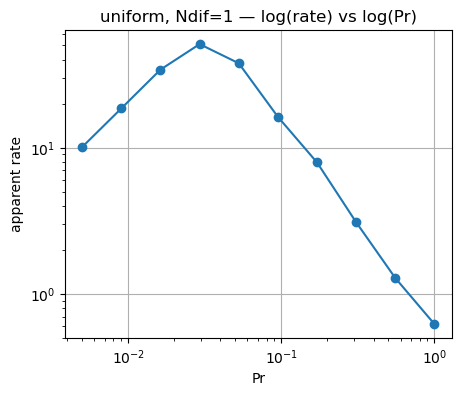

[uniform, Ndif=1] slopes  low≈0.93, mid≈-1.33, high≈-1.36


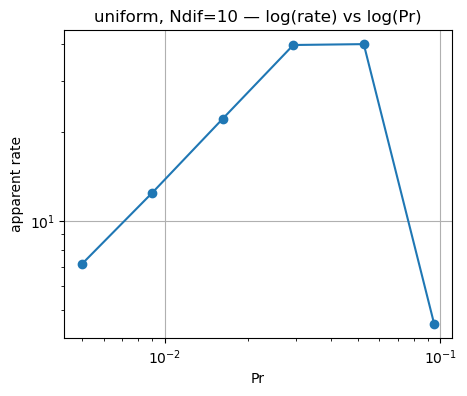

[uniform, Ndif=10] slopes  low≈0.97, mid≈-3.72, high≈nan


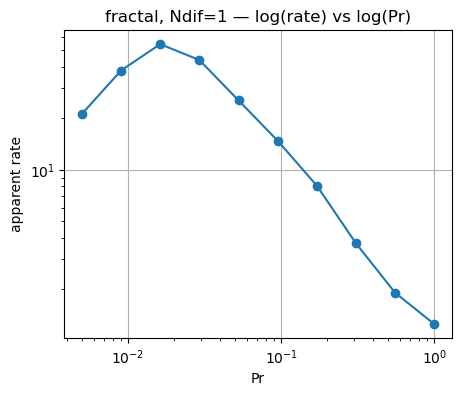

[fractal, Ndif=1] slopes  low≈0.43, mid≈-0.97, high≈-0.92


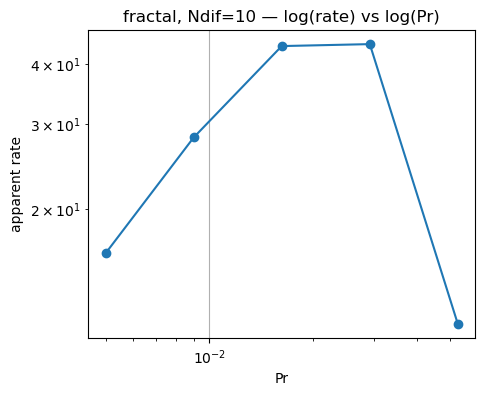

[fractal, Ndif=10] slopes  low≈0.58, mid≈nan, high≈nan


In [6]:
# === Step 5: Pr 스윕 & 레짐 시각화 (uniform vs fractal, Ndif=1/10) ===
import numpy as np
import matplotlib.pyplot as plt

def sweep_Pr_curves(struct="fractal", level=3, k_keep=20, Ndif=1, Pr_list=None,
                    mcs_total=1200, mcs_burn=600, n_atm=50, seed=0):
    """
    주어진 구조(struct)와 Ndif에서 Pr를 스윕하여 apparent rate 곡선을 반환
    """
    rng = np.random.default_rng(seed)
    if Pr_list is None:
        Pr_list = np.geomspace(5e-3, 1.0, 10)
    rates = []
    for Pr in Pr_list:
        # 구조 생성
        if struct == "fractal":
            solid = build_menger(level, k_keep)
        else:
            solid = build_uniform(level)

        # 시뮬레이션 실행
        intr, app, *_ = run_sim(solid, Ndif=Ndif, Pr=Pr, 
                                 mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        rates.append(app)
    return np.array(Pr_list), np.array(rates)

def plot_regimes(level=3, k_keep=20, mcs_total=1200, mcs_burn=600, n_atm=50):
    """
    uniform vs fractal, Ndif=1/10에 대해 log–log 플롯과 구간별 기울기(선형회귀)를 출력
    """
    setups = [("uniform", 1), ("uniform", 10), ("fractal", 1), ("fractal", 10)]
    for struct, Ndif in setups:
        Pr, rate = sweep_Pr_curves(struct=struct, level=level, k_keep=k_keep, Ndif=Ndif,
                                   mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        m = rate > 0
        Pr, rate = Pr[m], rate[m]
        if len(rate) == 0:
            print(f"[{struct}, Ndif={Ndif}] all-zero rates. Increase mcs_total/n_atm or widen Pr_list.")
            continue

        plt.figure(figsize=(5,4))
        plt.plot(Pr, rate, "o-")
        plt.xscale("log"); plt.yscale("log")
        plt.title(f"{struct}, Ndif={Ndif} — log(rate) vs log(Pr)")
        plt.xlabel("Pr"); plt.ylabel("apparent rate")
        plt.grid(True)
        plt.show()

        # 구간별 기울기(저/중/고 Pr)
        def slope(lo, hi):
            mask = (Pr>=lo) & (Pr<=hi)
            if mask.sum() < 2: return np.nan
            x = np.log10(Pr[mask]); y = np.log10(rate[mask])
            a, b = np.polyfit(x, y, 1)
            return a

        s_low  = slope(5e-3, 3e-2)
        s_mid  = slope(3e-2, 3e-1)
        s_high = slope(3e-1, 1.0)
        print(f"[{struct}, Ndif={Ndif}] slopes  low≈{s_low:.2f}, mid≈{s_mid:.2f}, high≈{s_high:.2f}")

# 바로 실행 예시 (시간이 좀 걸릴 수 있음)
# plot_regimes(level=3, k_keep=20, mcs_total=1200, mcs_burn=600, n_atm=50)


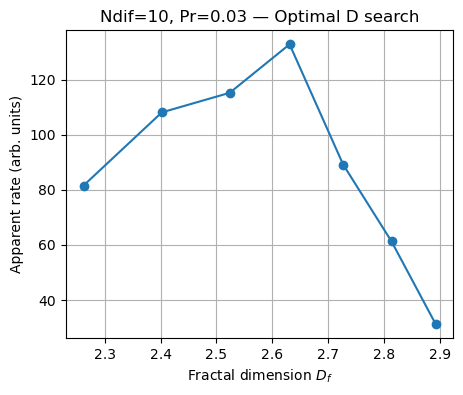

최적 Df ≈ 2.63, rate = 132.8100


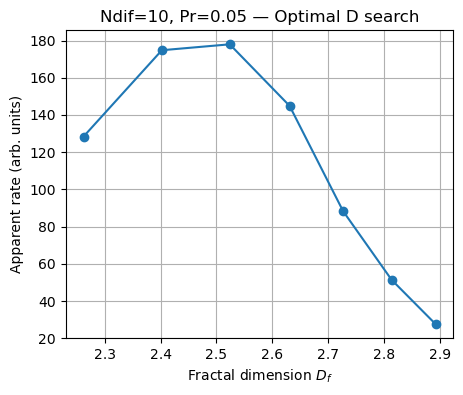

최적 Df ≈ 2.52, rate = 177.9800


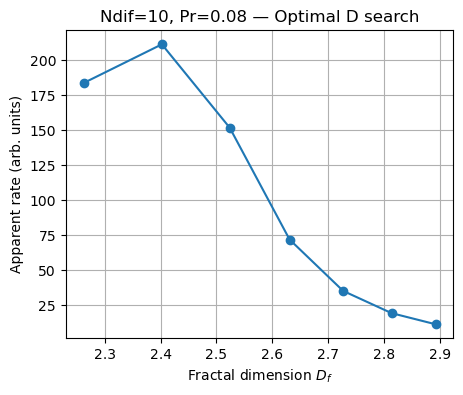

최적 Df ≈ 2.40, rate = 211.4867


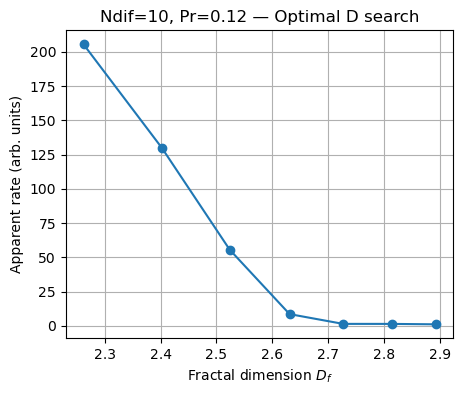

최적 Df ≈ 2.26, rate = 205.5450


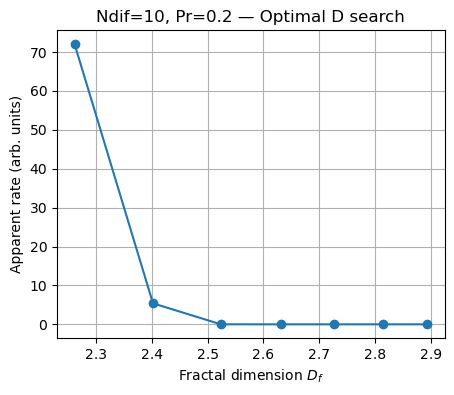

최적 Df ≈ 2.26, rate = 71.9717


In [9]:
# === Step 6: Df 스윕으로 최적 D 찾기 ===
import numpy as np
import matplotlib.pyplot as plt

def df_from_kkeep(k_keep, level=3):
    """
    Menger-like fractal에서 fractal dimension 계산:
    Df = log(k_keep)/log(3)  (단일 세대 기준)
    """
    return np.log(k_keep) / np.log(3)

def sweep_Df(level=3, k_keep_list=(10, 15, 20), 
             Ndif=1, Pr=0.05, 
             mcs_total=600, mcs_burn=300, n_atm=20, seed=0):
    """
    서로 다른 k_keep (즉 서로 다른 Df)에 대해 apparent rate 비교
    """
    rng = np.random.default_rng(seed)
    Ds, rates = [], []
    for kk in k_keep_list:
        solid = build_menger(level, k_keep=kk)
        intr, app, *_ = run_sim(solid, Ndif=Ndif, Pr=Pr,
                                mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        Ds.append(df_from_kkeep(kk, level=level))
        rates.append(app)
    return np.array(Ds), np.array(rates)

def plot_optimal_D(level=3, k_keep_list=(8,12,15,18,20),
                   Ndif=1, Pr=0.05, 
                   mcs_total=600, mcs_burn=300, n_atm=20):
    Ds, rates = sweep_Df(level=level, k_keep_list=k_keep_list,
                         Ndif=Ndif, Pr=Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
    plt.figure(figsize=(5,4))
    plt.plot(Ds, rates, "o-")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Apparent rate (arb. units)")
    plt.title(f"Ndif={Ndif}, Pr={Pr} — Optimal D search")
    plt.grid(True)
    plt.show()

    idx = np.argmax(rates)
    print(f"최적 Df ≈ {Ds[idx]:.2f}, rate = {rates[idx]:.4f}")

# 실행 예시: 여러 Pr 값을 돌려보기
k_keep_list = [12,14,16,18,20,22,24]  # Df ≈ 2.26 ~ 2.89

for Pr in [0.03, 0.05, 0.08, 0.12, 0.2]:
    plot_optimal_D(
        level=3,
        k_keep_list=k_keep_list,
        Ndif=10,               # Knudsen regime
        Pr=Pr,                 # sweep over different Pr
        mcs_total=1200,
        mcs_burn=600,
        n_atm=80
    )